In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

bee_colony_data = pd.read_csv('all_merged.csv')
bee_colony_data.head(n=5)

,Unnamed: 0,State,year,quarter,Starting colonies,Maximum colonies,Lost colonies,Percent lost,Added colonies,Varroa mites,Other pests,Diseases,Pesticides,Other,Unknown
0,1,Alabama,2015,Q1,7000,7000,1800,26,2800,10.0,5.4,(Z),2.2,9.1,9.4
1,2,Alabama,2015,Q2,7500,7500,860,12,1900,16.7,42.5,(Z),2.3,3.2,4.1
2,3,Alabama,2015,Q3,8500,9000,1400,16,160,63.1,70.6,(Z),2.6,2.2,17.7
3,4,Alabama,2015,Q4,8000,8000,610,8,80,3.1,6.4,0.2,0.2,2.8,1.9
4,5,Alabama,2016,Q1,7500,7500,1700,23,1200,24.2,22.0,4.3,8.1,2.4,11.3


Remove null data - the (Z) value, per the initial info, were values too small to record

In [2]:
bee_colony_data.replace({'(Z)': '', '(NA)': '', '-': ''}, inplace=True)
bee_colony_data.head(n=5)

,Unnamed: 0,State,year,quarter,Starting colonies,Maximum colonies,Lost colonies,Percent lost,Added colonies,Varroa mites,Other pests,Diseases,Pesticides,Other,Unknown
0,1,Alabama,2015,Q1,7000,7000,1800,26,2800,10.0,5.4,,2.2,9.1,9.4
1,2,Alabama,2015,Q2,7500,7500,860,12,1900,16.7,42.5,,2.3,3.2,4.1
2,3,Alabama,2015,Q3,8500,9000,1400,16,160,63.1,70.6,,2.6,2.2,17.7
3,4,Alabama,2015,Q4,8000,8000,610,8,80,3.1,6.4,0.2,0.2,2.8,1.9
4,5,Alabama,2016,Q1,7500,7500,1700,23,1200,24.2,22.0,4.3,8.1,2.4,11.3


In [3]:
numeric_cols = ['Starting colonies', 'Maximum colonies', 'Lost colonies', 'Percent lost', 'Added colonies', 'Varroa mites', 'Other pests', 'Diseases', 'Pesticides', 'Other', 'Unknown']
bee_colony_data[numeric_cols] = bee_colony_data[numeric_cols].apply(pd.to_numeric, errors='coerce', axis=1)
bee_colony_data = bee_colony_data.drop(['Unnamed: 0'], axis=1)
bee_colony_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575 entries, 0 to 1574
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   State              1575 non-null   object 
 1   year               1575 non-null   int64  
 2   quarter            1575 non-null   object 
 3   Starting colonies  1530 non-null   float64
 4   Maximum colonies   1528 non-null   float64
 5   Lost colonies      1522 non-null   float64
 6   Percent lost       1513 non-null   float64
 7   Added colonies     1481 non-null   float64
 8   Varroa mites       1431 non-null   float64
 9   Other pests        1341 non-null   float64
 10  Diseases           1176 non-null   float64
 11  Pesticides         1189 non-null   float64
 12  Other              1409 non-null   float64
 13  Unknown            1335 non-null   float64
dtypes: float64(11), int64(1), object(2)
memory usage: 172.4+ KB


In [4]:
bee_colony_data.isnull().sum(axis=0)
# Could probably replace the null values in all columns from Varroa mites to the end with 0. 
# Will wait and see if this makes a difference

State                  0
year                   0
quarter                0
Starting colonies     45
Maximum colonies      47
Lost colonies         53
Percent lost          62
Added colonies        94
Varroa mites         144
Other pests          234
Diseases             399
Pesticides           386
Other                166
Unknown              240
dtype: int64

<AxesSubplot:xlabel='Lost colonies', ylabel='Count'>

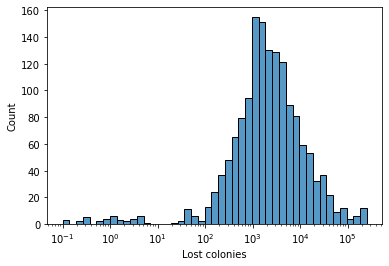

In [5]:
# Check distribution of lost colonies
sns.histplot(x="Lost colonies", data=bee_colony_data, log_scale=True)

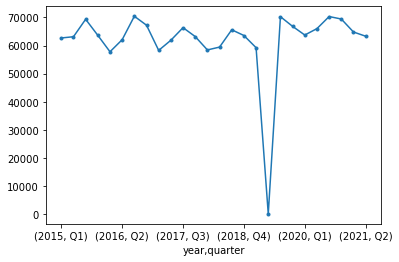

In [6]:
# Do an initial plot of time data
bee_data_quarter_group = (
  bee_colony_data.groupby(["year", "quarter"]).agg({"Starting colonies": "mean"}))

bee_data_quarter_group["Starting colonies"].plot(marker=".");

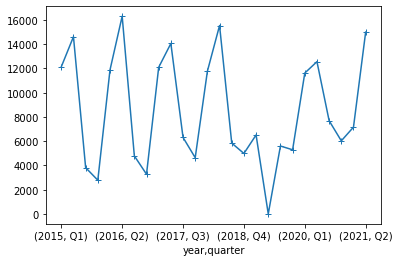

In [7]:
# Okay, since the value is zero, this looks like a big chunk of missing data. What do Added colonies look like?
bee_data_quarter_group = (
  bee_colony_data.groupby(["year", "quarter"]).agg({"Added colonies": "mean"}))

bee_data_quarter_group["Added colonies"].plot(marker="+");
# Something is definitely wrong with the data. There would have been a spike in colony additions if there were a bunch lost

I went back and looked at the source data. For a reason unexplained by the note, it was stated that data collection was suspended for the April 2019 (Q2) quarter. So, removing that from the dataset.

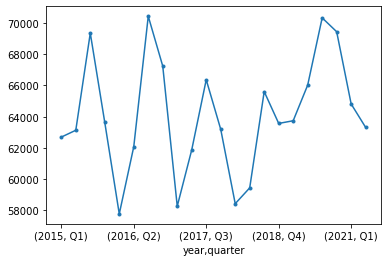

In [8]:
bee_colony_data = bee_colony_data[(bee_colony_data['year'] != 2019) & (bee_colony_data['Starting colonies'].notna())]

#Okay, let's check if the null quarter is really gone
bee_data_quarter_group = (
  bee_colony_data.groupby(["year", "quarter"]).agg({"Starting colonies": "mean"}))

bee_data_quarter_group["Starting colonies"].plot(marker=".");

Now that the problem with the data is fixed, let's check the distribution of the data

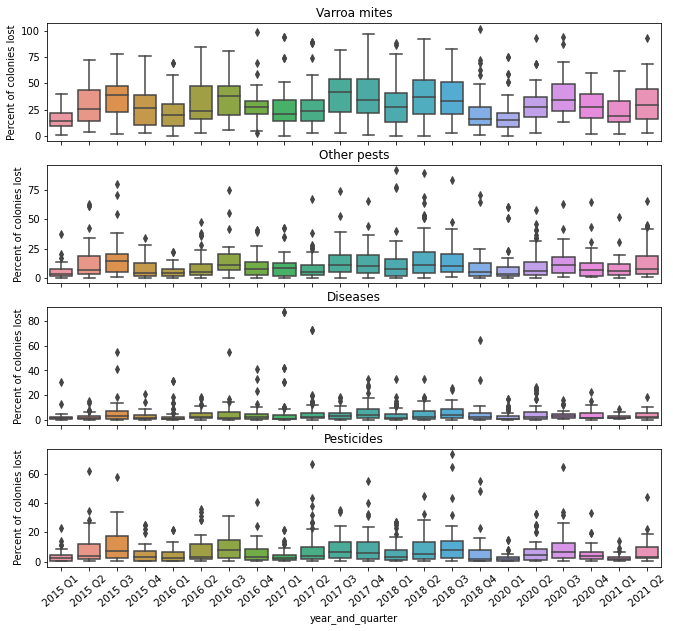

In [9]:
# I want to put the year and quarter on the X axis, and seaborn isn't liking the group by to combine two columns
# So, making a single column for time
bee_colony_data['year_and_quarter'] = bee_colony_data['year'].map(str) + ' ' + bee_colony_data['quarter']

fig, axes = plt.subplots(4, 1, figsize=(11, 10), sharex=True)
plt.xticks(rotation = 40)
for name, ax in zip(['Varroa mites', 'Other pests', 'Diseases', 'Pesticides'], axes):
    sns.boxplot(data=bee_colony_data, x='year_and_quarter', y=name, ax=ax)
    ax.set_ylabel('Percent of colonies lost')
    ax.set_title(name)
    if ax != axes[-1]:
        ax.set_xlabel('')

Now let's do a violin plot to see if that's more illuminating than the boxplots.

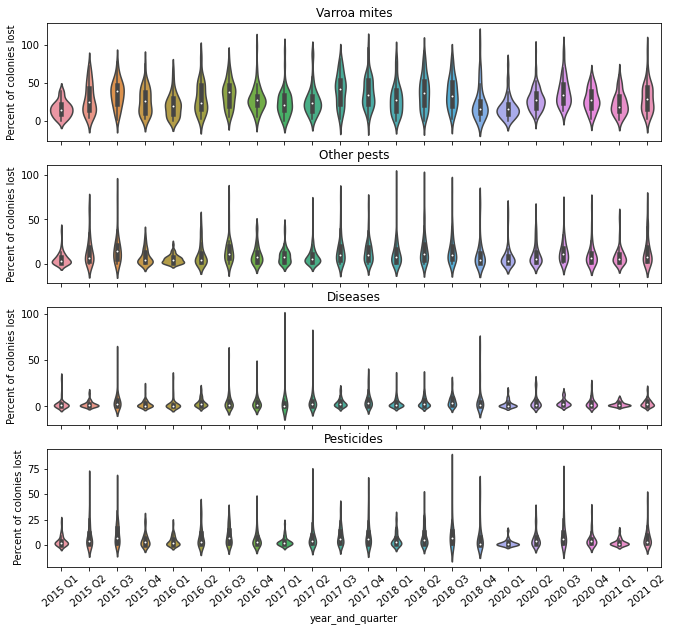

In [10]:
fig, axes = plt.subplots(4, 1, figsize=(11, 10), sharex=True)
plt.xticks(rotation = 40)
for name, ax in zip(['Varroa mites', 'Other pests', 'Diseases', 'Pesticides'], axes):
    sns.violinplot(data=bee_colony_data, x='year_and_quarter', y=name, ax=ax)
    ax.set_ylabel('Percent of colonies lost')
    ax.set_title(name)
    if ax != axes[-1]:
        ax.set_xlabel('')

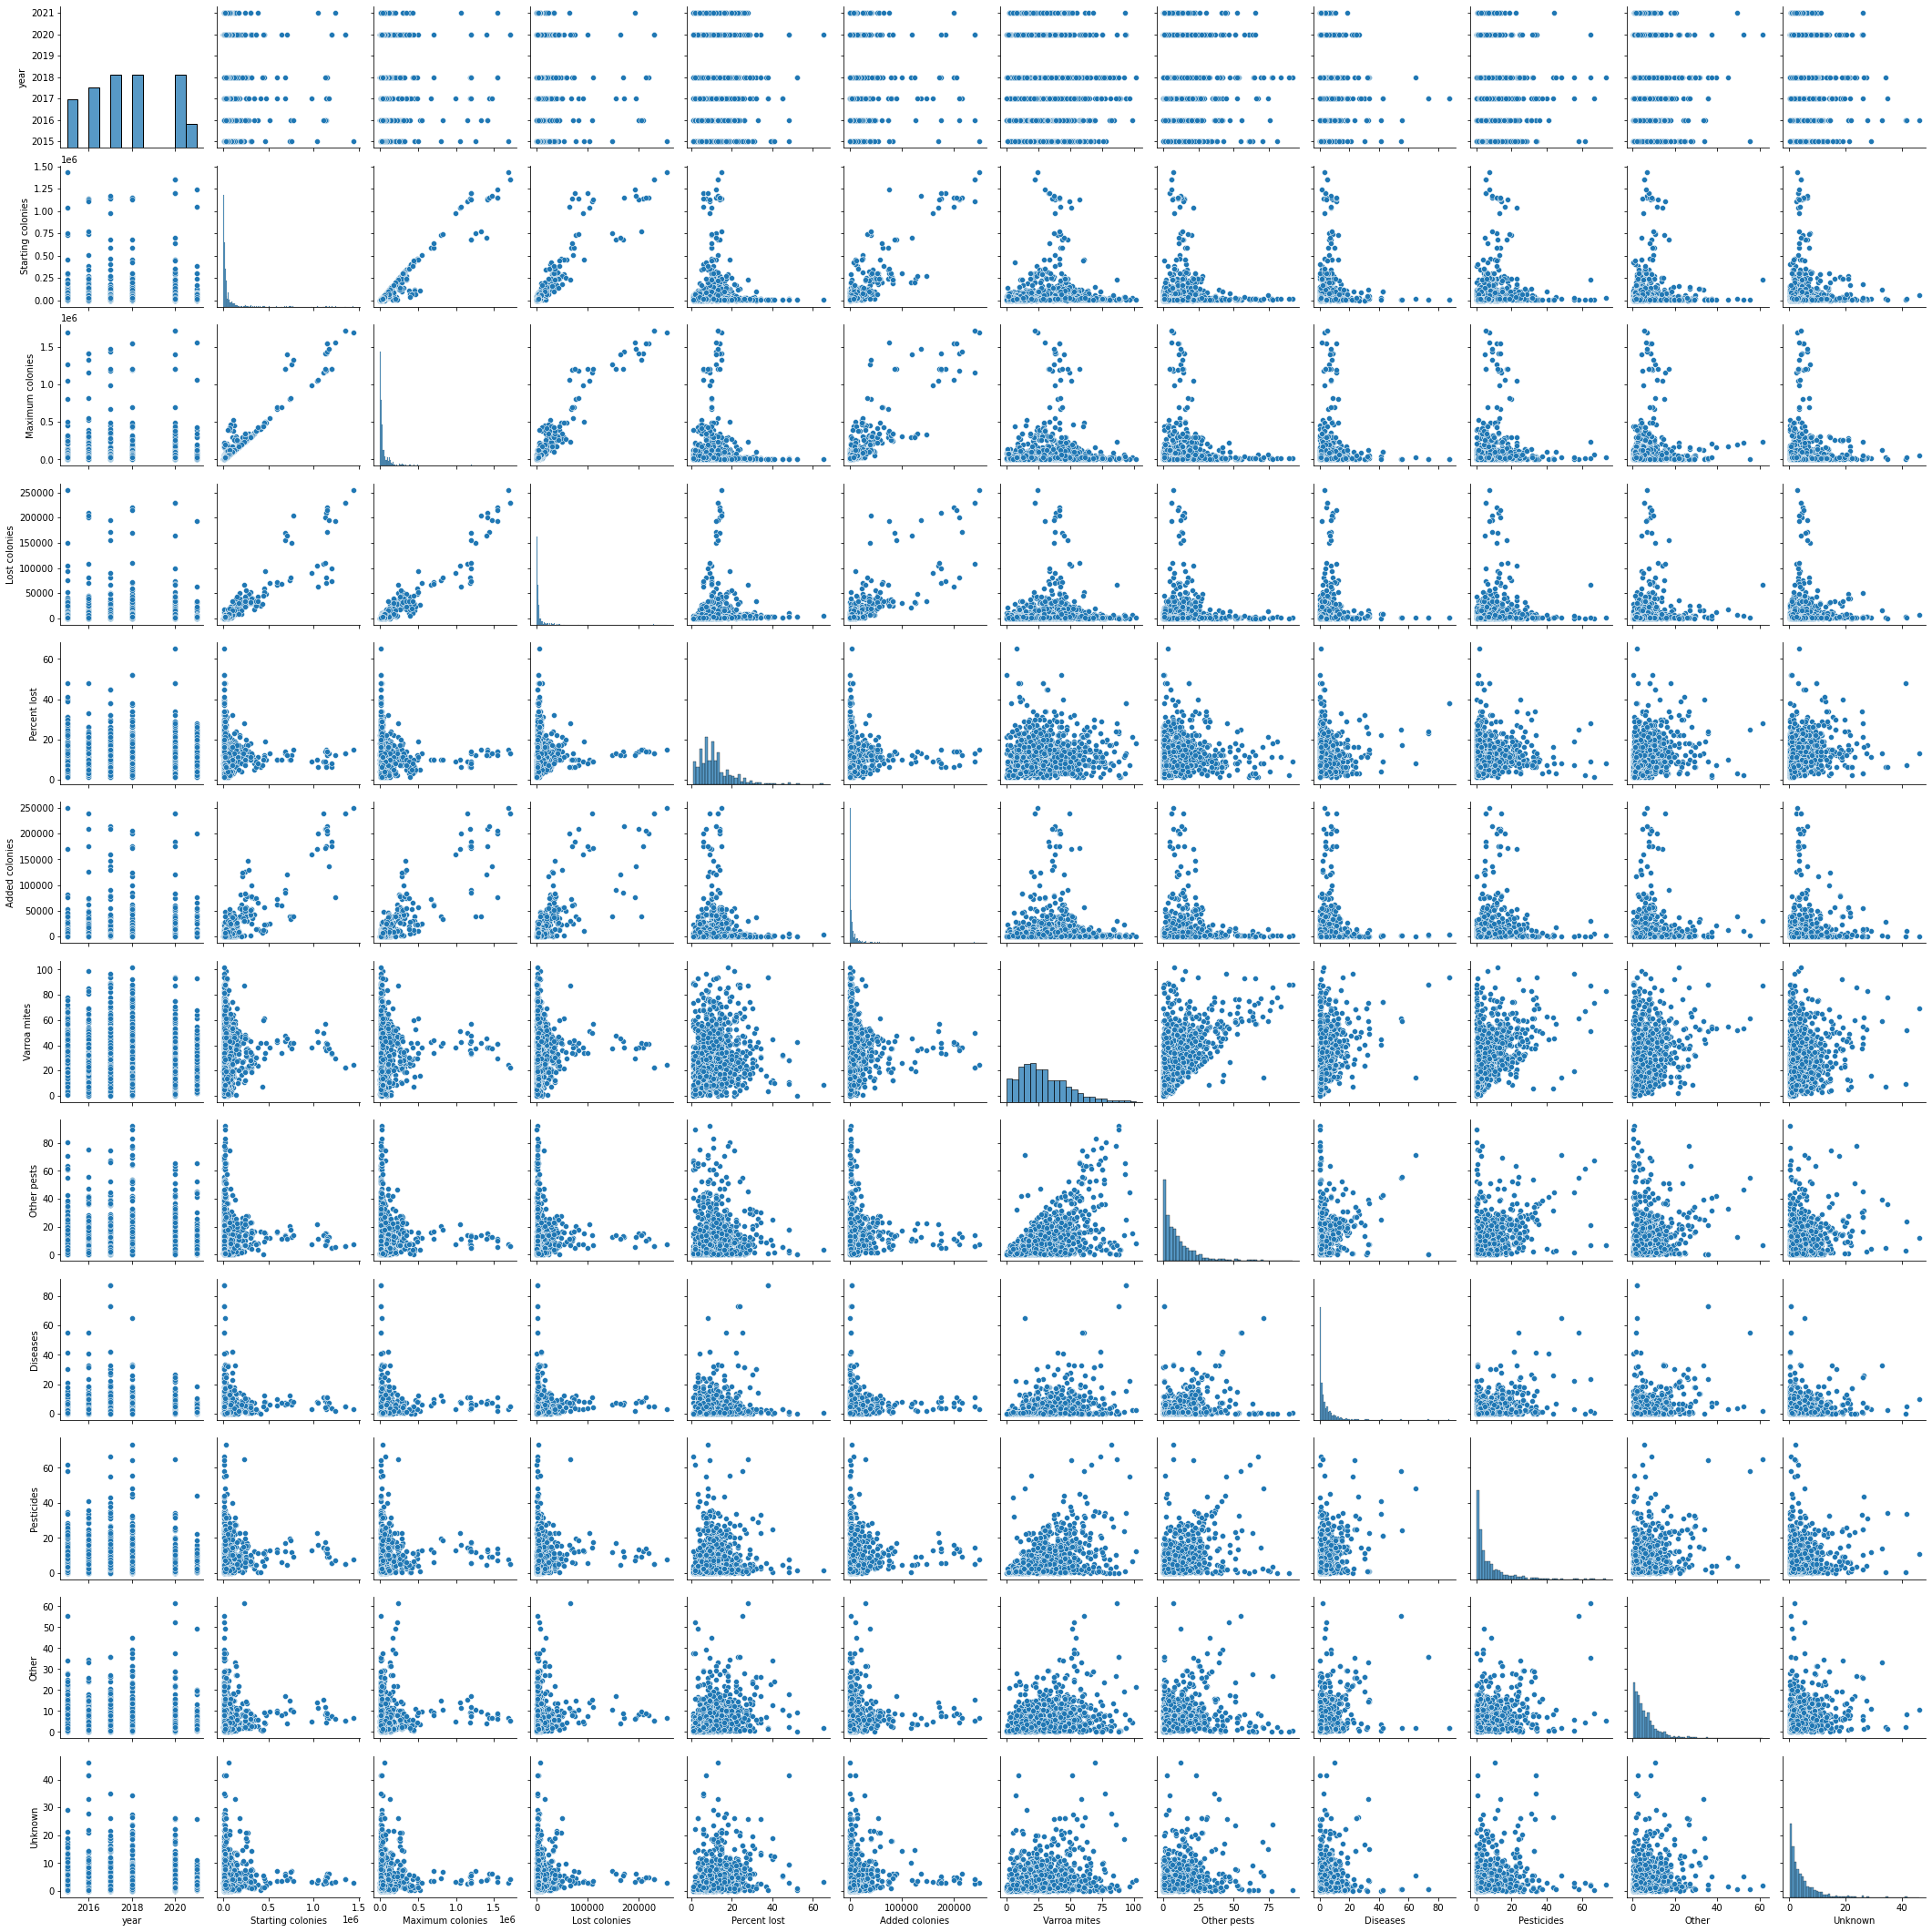

In [11]:
# And let's do a pairplot, just out of curiosity
sns.pairplot(bee_colony_data)
plt.show()

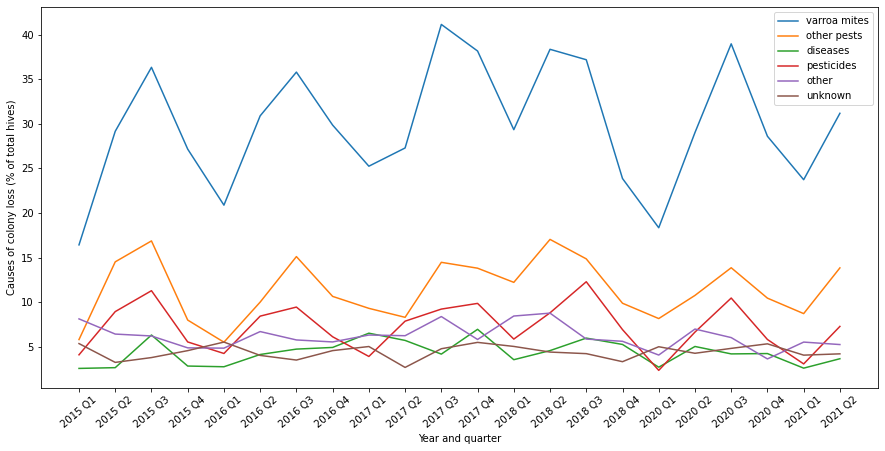

In [12]:
# Digging into the reasons for hive loss and how they change over time
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(x='year_and_quarter', y='Varroa mites', data=bee_colony_data, ci=None, label='varroa mites')
sns.lineplot(x='year_and_quarter', y='Other pests', data=bee_colony_data, ci=None, label='other pests')
sns.lineplot(x='year_and_quarter', y='Diseases', data=bee_colony_data, ci=None, label='diseases')
sns.lineplot(x='year_and_quarter', y='Pesticides', data=bee_colony_data, ci=None, label='pesticides')
sns.lineplot(x='year_and_quarter', y='Other', data=bee_colony_data, ci=None, label='other')
sns.lineplot(x='year_and_quarter', y='Unknown', data=bee_colony_data, ci=None, label='unknown')

ax.set_ylabel('Causes of colony loss (% of total hives)')
ax.set_xlabel('Year and quarter')
ax.legend()
plt.xticks(rotation = 40)
plt.show()

That's unexpected. I'd have assumed that pesticides would be much higher than they are. Though data couldn't show how pesticides might weaken a hive making it more susceptible to pesticides.

Let's try just looking at one quarter at a time - e.g. only the causes for one quarter at a time since the data is so seasonal

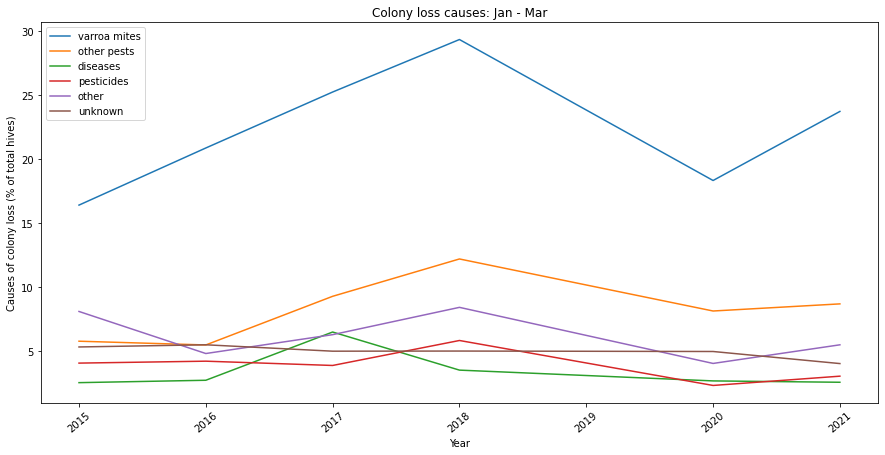

In [13]:
fig, ax = plt.subplots(figsize=(15, 7))
winter = bee_colony_data[bee_colony_data['quarter'] == 'Q1']
sns.lineplot(x='year', y='Varroa mites', data=winter, ci=None, label='varroa mites')
sns.lineplot(x='year', y='Other pests', data=winter, ci=None, label='other pests')
sns.lineplot(x='year', y='Diseases', data=winter, ci=None, label='diseases')
sns.lineplot(x='year', y='Pesticides', data=winter, ci=None, label='pesticides')
sns.lineplot(x='year', y='Other', data=winter, ci=None, label='other')
sns.lineplot(x='year', y='Unknown', data=winter, ci=None, label='unknown')

ax.set_ylabel('Causes of colony loss (% of total hives)')
ax.set_xlabel('Year')
ax.set_title('Colony loss causes: Jan - Mar')
ax.legend()
plt.xticks(rotation = 40)
plt.show()

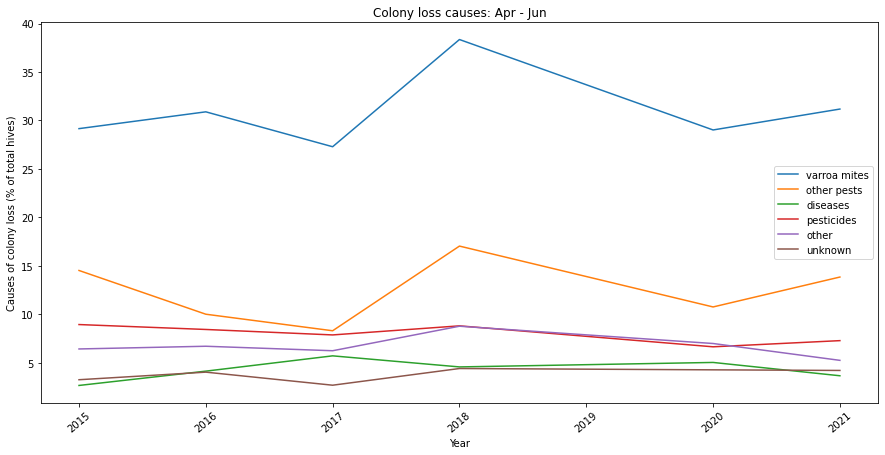

In [14]:
fig, ax = plt.subplots(figsize=(15, 7))
spring = bee_colony_data[bee_colony_data['quarter'] == 'Q2']
sns.lineplot(x='year', y='Varroa mites', data=spring, ci=None, label='varroa mites')
sns.lineplot(x='year', y='Other pests', data=spring, ci=None, label='other pests')
sns.lineplot(x='year', y='Diseases', data=spring, ci=None, label='diseases')
sns.lineplot(x='year', y='Pesticides', data=spring, ci=None, label='pesticides')
sns.lineplot(x='year', y='Other', data=spring, ci=None, label='other')
sns.lineplot(x='year', y='Unknown', data=spring, ci=None, label='unknown')

ax.set_ylabel('Causes of colony loss (% of total hives)')
ax.set_xlabel('Year')
ax.set_title('Colony loss causes: Apr - Jun')
ax.legend()
plt.xticks(rotation = 40)
plt.show()

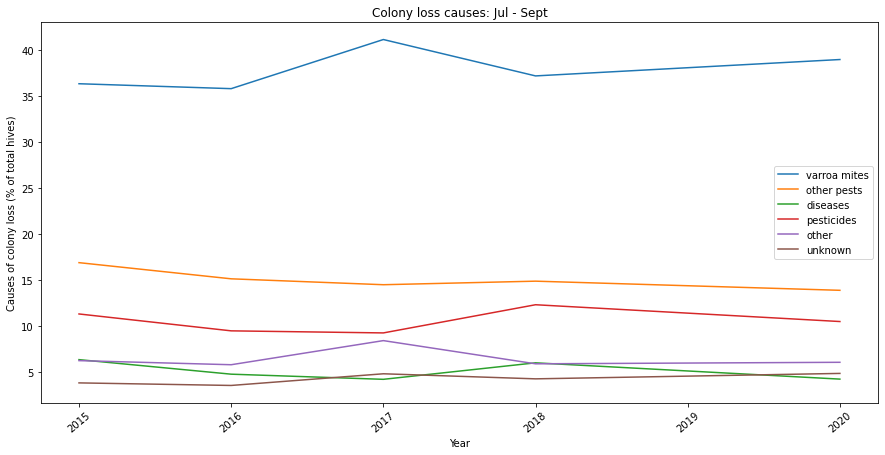

In [15]:
fig, ax = plt.subplots(figsize=(15, 7))
summer = bee_colony_data[bee_colony_data['quarter'] == 'Q3']
sns.lineplot(x='year', y='Varroa mites', data=summer, ci=None, label='varroa mites')
sns.lineplot(x='year', y='Other pests', data=summer, ci=None, label='other pests')
sns.lineplot(x='year', y='Diseases', data=summer, ci=None, label='diseases')
sns.lineplot(x='year', y='Pesticides', data=summer, ci=None, label='pesticides')
sns.lineplot(x='year', y='Other', data=summer, ci=None, label='other')
sns.lineplot(x='year', y='Unknown', data=summer, ci=None, label='unknown')

ax.set_ylabel('Causes of colony loss (% of total hives)')
ax.set_xlabel('Year')
ax.set_title('Colony loss causes: Jul - Sept')
ax.legend()
plt.xticks(rotation = 40)
plt.show()

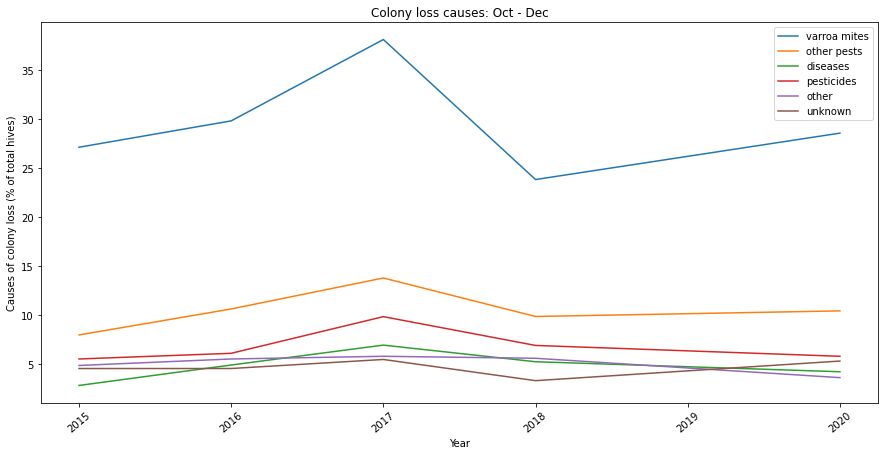

In [16]:
fig, ax = plt.subplots(figsize=(15, 7))
winter = bee_colony_data[bee_colony_data['quarter'] == 'Q4']
sns.lineplot(x='year', y='Varroa mites', data=winter, ci=None, label='varroa mites')
sns.lineplot(x='year', y='Other pests', data=winter, ci=None, label='other pests')
sns.lineplot(x='year', y='Diseases', data=winter, ci=None, label='diseases')
sns.lineplot(x='year', y='Pesticides', data=winter, ci=None, label='pesticides')
sns.lineplot(x='year', y='Other', data=winter, ci=None, label='other')
sns.lineplot(x='year', y='Unknown', data=winter, ci=None, label='unknown')

ax.set_ylabel('Causes of colony loss (% of total hives)')
ax.set_xlabel('Year')
ax.set_title('Colony loss causes: Oct - Dec')
ax.legend()
plt.xticks(rotation = 40)
plt.show()

Out of curiosity, I wonder what the numbers look like when you compare just a few states, with varroa mites on one graph and pesticides on another. Let's try a handful of agricultural states scattered across regions: California, Nebraska, Wisconsin, Georgia, and Maine. 

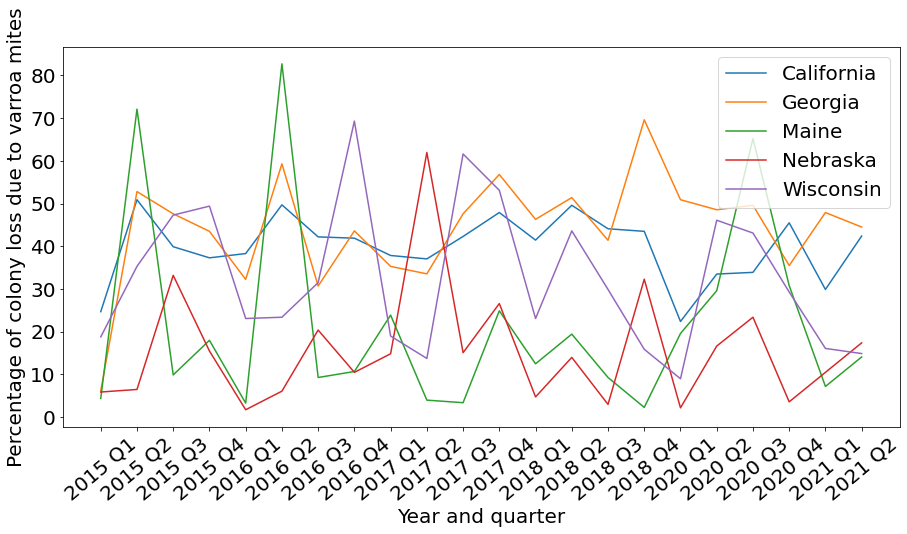

In [18]:
fig, ax = plt.subplots(figsize=(15, 7))
states = ['California', 'Nebraska', 'Wisconsin', 'Georgia', 'Maine']
ag_states = bee_colony_data[bee_colony_data['State'].isin(states)]
sns.lineplot(x='year_and_quarter', y='Varroa mites', data=ag_states, ci=None, hue="State")

ax.set_ylabel('Percentage of colony loss due to varroa mites')
ax.set_xlabel('Year and quarter')
ax.legend()
plt.xticks(rotation = 40)
plt.rcParams['figure.figsize'] = 18, 12
plt.rc('font', size=20)
plt.show()


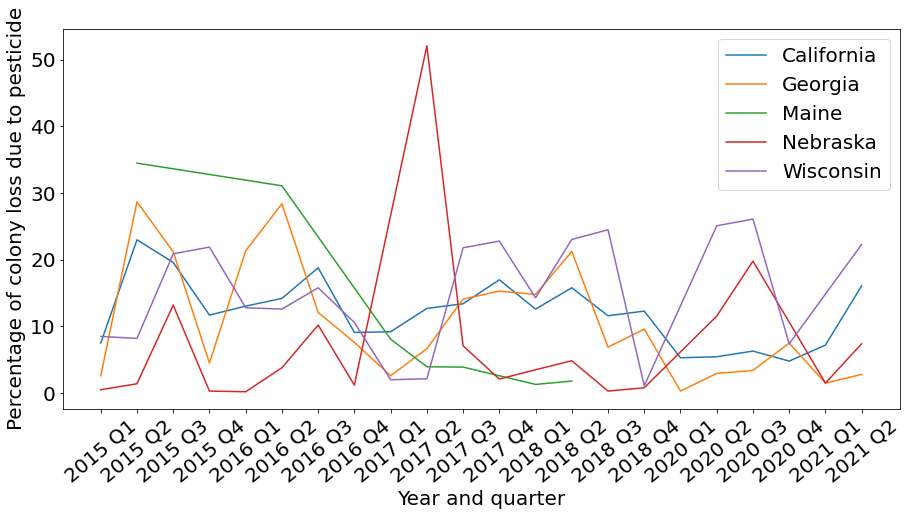

In [19]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(x='year_and_quarter', y='Pesticides', data=ag_states, ci=None, hue="State")

ax.set_ylabel('Percentage of colony loss due to pesticide')
ax.set_xlabel('Year and quarter')
ax.legend()
plt.xticks(rotation = 40)
plt.rcParams['figure.figsize'] = 18, 12
plt.rc('font', size=20)
plt.show()

The big jump in colony loss due to pesticides in Nebraska in 2017 is interesting, but hard to see any other trends here.

We're getting a lot of noise, since bee colony loss happens on a largely seasonal pattern. Q2 is the prime time for a hive to be large enough from surviving winter to be able to split or for a hive to falter after a hard winter. And October to December is typically after honey is harvested and when the colony is weakened. Let's try this again with just Q2 and then another set of graphs for Q4.

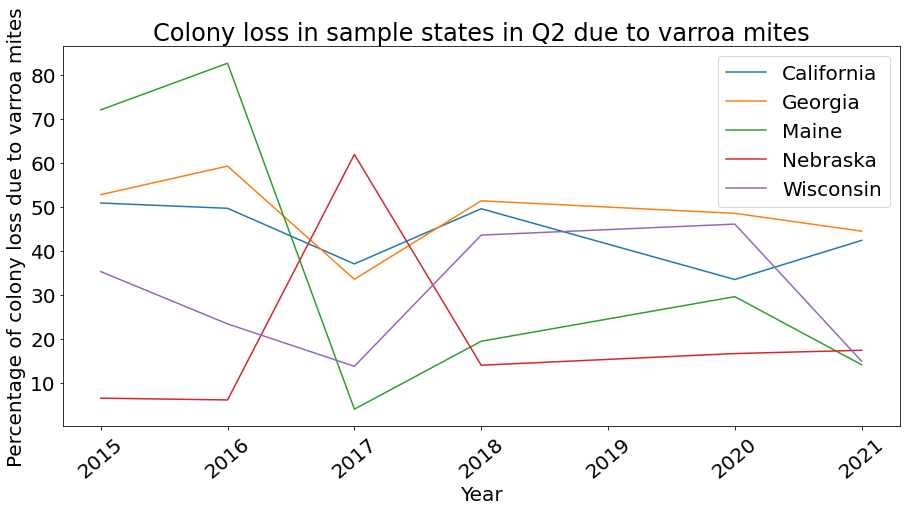

In [20]:
fig, ax = plt.subplots(figsize=(15, 7))
ag_states_Q2 = ag_states[ag_states['quarter'] == 'Q2']

sns.lineplot(x='year', y='Varroa mites', data=ag_states_Q2, ci=None, hue="State")

ax.set_ylabel('Percentage of colony loss due to varroa mites')
ax.set_xlabel('Year')
plt.title('Colony loss in sample states in Q2 due to varroa mites')
ax.legend()
plt.xticks(rotation = 40)
plt.show()

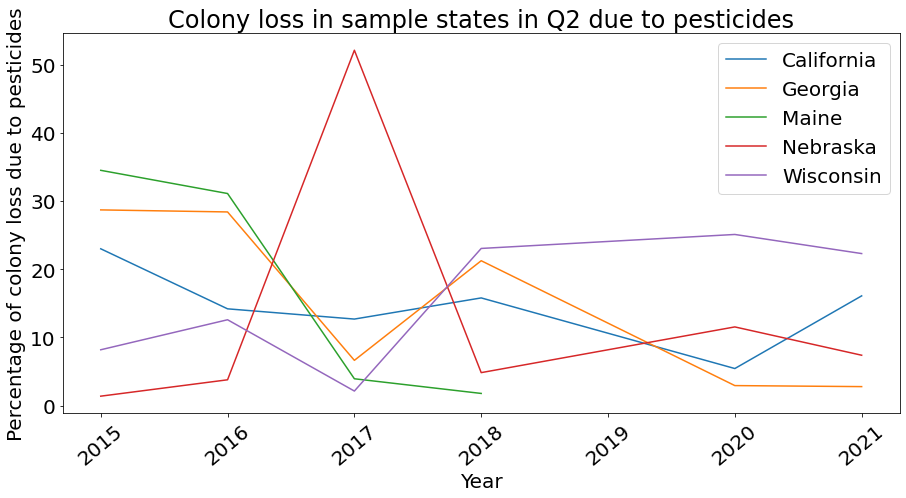

In [21]:
fig, ax = plt.subplots(figsize=(15, 7))
ag_states_Q2 = ag_states[ag_states['quarter'] == 'Q2']

sns.lineplot(x='year', y='Pesticides', data=ag_states_Q2, ci=None, hue="State")

ax.set_ylabel('Percentage of colony loss due to pesticides')
ax.set_xlabel('Year')
ax.legend()
plt.title('Colony loss in sample states in Q2 due to pesticides')
plt.xticks(rotation = 40)
plt.show()

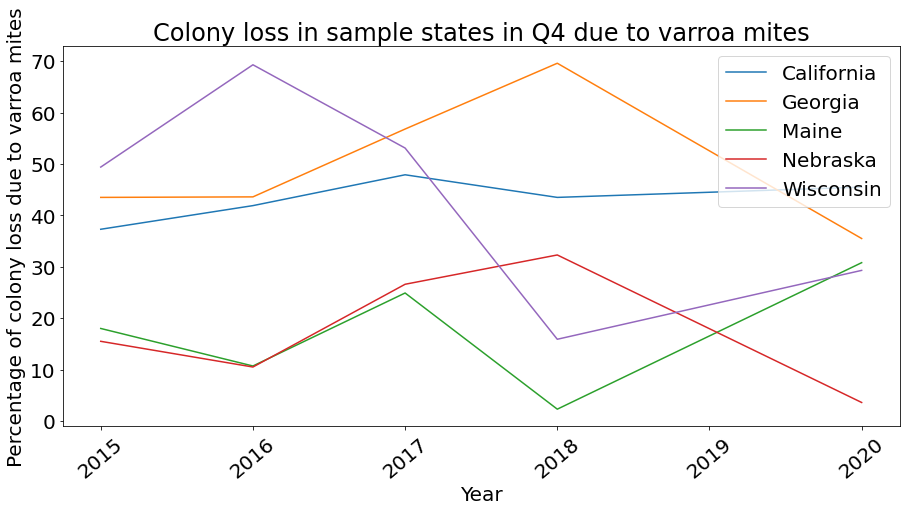

In [22]:
fig, ax = plt.subplots(figsize=(15, 7))
ag_states_Q4 = ag_states[ag_states['quarter'] == 'Q4']

sns.lineplot(x='year', y='Varroa mites', data=ag_states_Q4, ci=None, hue="State")

ax.set_ylabel('Percentage of colony loss due to varroa mites')
ax.set_xlabel('Year')
ax.legend()
plt.title('Colony loss in sample states in Q4 due to varroa mites')
plt.xticks(rotation = 40)
plt.show()

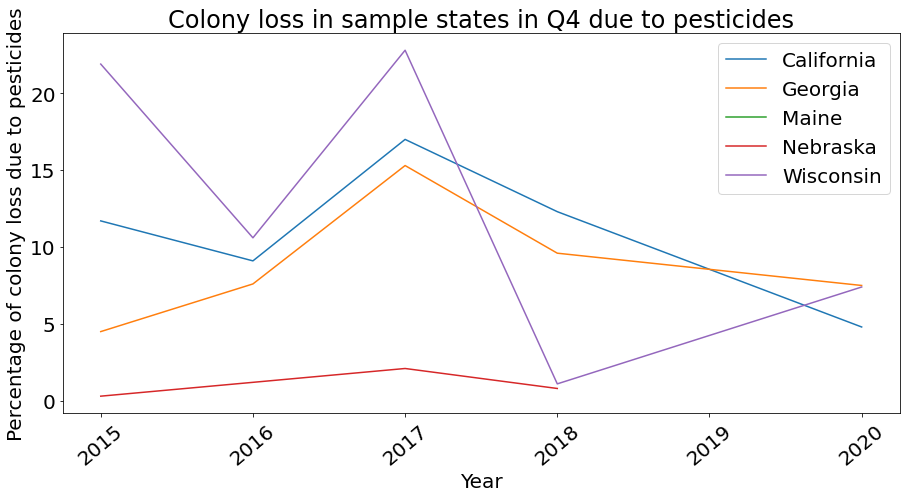

In [23]:
fig, ax = plt.subplots(figsize=(15, 7))
ag_states_Q4 = ag_states[ag_states['quarter'] == 'Q4']

sns.lineplot(x='year', y='Pesticides', data=ag_states_Q4, ci=None, hue="State")

ax.set_ylabel('Percentage of colony loss due to pesticides')
ax.set_xlabel('Year')
ax.legend()
plt.title('Colony loss in sample states in Q4 due to pesticides')
plt.xticks(rotation = 40)
plt.show()

Maine has no data for pesticides in Q4, likely due to not opening hives during those months. (Hives are left undisturbed during very cold months to let the bees regulate their own heat)

Overall, it's interesting to see pesticide loss trend downward across most states in both Q2 and Q4. Varroa mites are more variable. 

Next up, I'll put the states into regions and run analysis across the regions, since my hypothesis is that the cause of colony loss is different in the northern Midwest states than elsewhere.

I'm using the census bureau designations to split up the country: https://en.wikipedia.org/wiki/List_of_regions_of_the_United_States  This does require removing Iowa and Minnesota from the region I'm focused on for the hypothesis and adding Ohio. 

In [26]:
# Map regions to new column
south_states = ['Alabama', 'Arkansas', 'Delaware', 'Florida', 'Georgia', 'Kentucky', 'Louisiana', 'Maryland', 
                'Mississippi', 'North Carolina', 'Oklahoma', 'South Carolina', 'Tennessee', 'Texas', 
                'Virginia', 'West Virginia']
west_states = ['Alaska', 'California', 'Colorado', 'Hawaii', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 
               'Oregon', 'Utah', 'Wyoming', 'Washington']
northeast_states = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'New Jersey', 'New York', 
                    'Pennsylvania', 'Rhode Island', 'Vermont']
midwest_states = ['Illinois', 'Indiana', 'Iowa', 'Kansas', 'Michigan', 'Minnesota', 'Missouri', 'Nebraska', 
                  'North Dakota', 'South Dakota', 'Ohio', 'Wisconsin']

state_region_map = {}
south_map = {state: 'south' for state in south_states}
west_map = {state: 'west' for state in west_states}
northeast_map = {state: 'northeast' for state in northeast_states}
midwest_map = {state: 'midwest' for state in midwest_states}

state_region_map.update(south_map)
state_region_map.update(west_map)
state_region_map.update(northeast_map)
state_region_map.update(midwest_map)

bee_colony_data['region'] = ''
bee_colony_data["region"] = bee_colony_data['State'].map(state_region_map)

# Map sub-regions to new column
east_south_central_sr = ['Alabama', 'Kentucky', 'Mississippi', 'Tennessee']
west_south_central_sr = ['Arkansas', 'Louisiana', 'Oklahoma', 'Texas']
south_atlantic_sr = ['Delaware', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 
                     'Virginia', 'West Virginia']
mountain_sr = ['Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah', 'Wyoming']
pacific_sr = ['Alaska', 'California', 'Hawaii', 'Oregon', 'Washington']
new_england_sr = ['Connecticut', 'Maine' 'Masschusetts', 'New Hampshire', 'Rhode Island', 'Vermont']
mid_atlantic_sr = ['New Jersey', 'New York', 'Pennsylvania']
east_north_central_sr = ['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin']
west_north_central_sr = ['Iowa', 'Kansas', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota']

state_subregion_map = {}
east_south_central_sr_map = {state: 'east south central' for state in east_south_central_sr}
west_south_central_sr_map = {state: 'west south central' for state in west_south_central_sr}
south_atlantic_sr_map = {state: 'south atlantic' for state in south_atlantic_sr}
mountain_sr_map = {state: 'mountain' for state in mountain_sr}
pacific_sr_map = {state: 'pacific' for state in pacific_sr}
new_england_sr_map = {state: 'new england' for state in new_england_sr}
mid_atlantic_sr_map = {state: 'mid atlantic' for state in mid_atlantic_sr}
east_north_central_sr_map = {state: 'east north central' for state in east_north_central_sr}
west_north_central_sr_map = {state: 'west north central' for state in west_north_central_sr}

state_subregion_map.update(east_south_central_sr_map)
state_subregion_map.update(west_south_central_sr_map)
state_subregion_map.update(south_atlantic_sr_map)
state_subregion_map.update(mountain_sr_map)
state_subregion_map.update(pacific_sr_map)
state_subregion_map.update(new_england_sr_map)
state_subregion_map.update(mid_atlantic_sr_map)
state_subregion_map.update(east_north_central_sr_map)
state_subregion_map.update(west_north_central_sr_map)

bee_colony_data['subregion'] = ''
bee_colony_data['subregion'] = bee_colony_data['State'].map(state_subregion_map)

,State,year,quarter,Starting colonies,Maximum colonies,Lost colonies,Percent lost,Added colonies,Varroa mites,Other pests,Diseases,Pesticides,Other,Unknown,year_and_quarter,region,subregion
1560,West Virginia,2020,Q4,7500.0,7500.0,550.0,7.0,120.0,7.2,4.3,NaN,1.0,4.5,1.1,2020 Q4,south,south atlantic
1561,West Virginia,2021,Q1,7000.0,7500.0,1200.0,16.0,1700.0,13.7,3.4,0.7,2.6,1.2,3.3,2021 Q1,south,south atlantic
1562,West Virginia,2021,Q2,8000.0,9000.0,170.0,2.0,1900.0,5.2,3.9,1.1,NaN,1.0,2.2,2021 Q2,south,south atlantic
1563,Wisconsin,2020,Q1,16000.0,28000.0,1900.0,7.0,700.0,9.0,1.9,NaN,NaN,2.7,3.1,2020 Q1,midwest,east north central
1564,Wisconsin,2020,Q2,27000.0,55000.0,1700.0,3.0,14000.0,46.1,27.3,25.0,25.1,25.8,26.1,2020 Q2,midwest,east north central
1565,Wisconsin,2020,Q3,68000.0,68000.0,8000.0,12.0,970.0,43.1,22.8,12.9,26.1,13.8,20.4,2020 Q3,midwest,east north central
1566,Wisconsin,2020,Q4,60000.0,60000.0,8000.0,13.0,2800.0,29.3,0.6,NaN,7.4,1.8,1.2,2020 Q4,midwest,east north central
1567,Wisconsin,2021,Q1,25000.0,37000.0,2500.0,7.0,7000.0,16.1,NaN,NaN,NaN,3.6,3.2,2021 Q1,midwest,east north central
1568,Wisconsin,2021,Q2,42000.0,57000.0,2200.0,4.0,9000.0,14.9,17.8,1.1,22.3,1.0,2.0,2021 Q2,midwest,east north central
1569,Wyoming,2020,Q1,4000.0,17000.0,140.0,1.0,450.0,NaN,NaN,0.1,NaN,0.8,1.7,2020 Q1,west,mountain


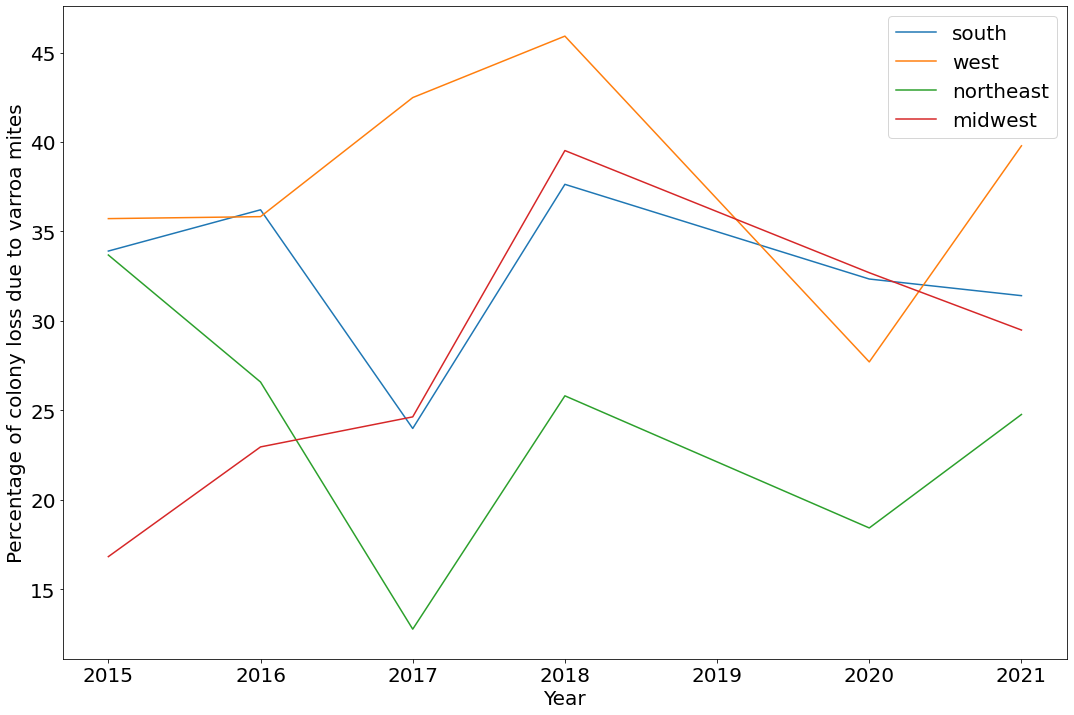

In [27]:
fig, ax = plt.subplots()
regional_q2 = bee_colony_data[bee_colony_data['quarter'] == 'Q2']
sns.lineplot(x='year', y='Varroa mites', data=regional_q2, ci=None, hue="region")

ax.set_ylabel('Percentage of colony loss due to varroa mites')
ax.set_xlabel('Year')
ax.legend()
plt.show()

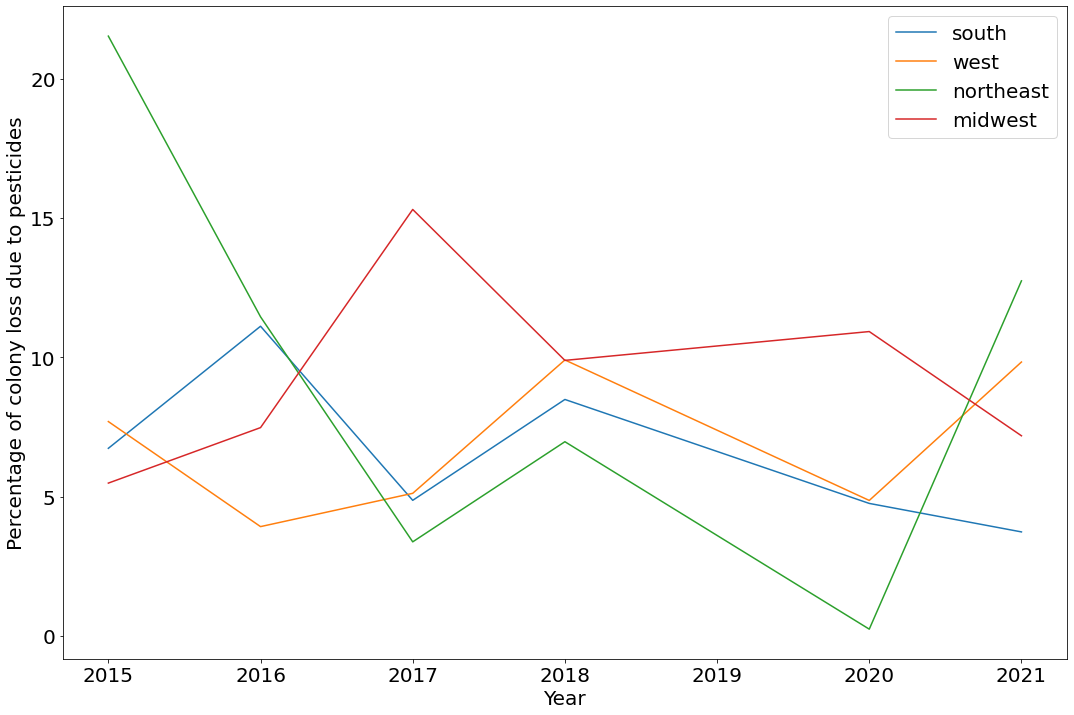

In [28]:
fig, ax = plt.subplots()
regional_q2 = bee_colony_data[bee_colony_data['quarter'] == 'Q2']
sns.lineplot(x='year', y='Pesticides', data=regional_q2, ci=None, hue="region")

ax.set_ylabel('Percentage of colony loss due to pesticides')
ax.set_xlabel('Year')
ax.legend()
plt.show()

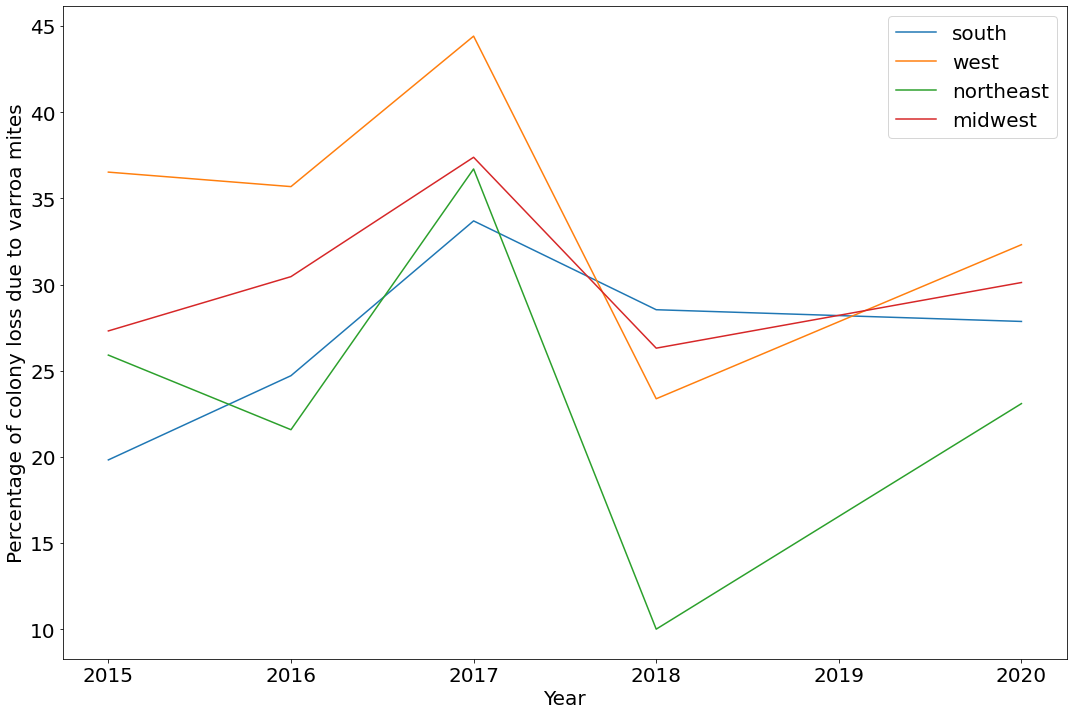

In [29]:
fig, ax = plt.subplots()
regional_q4 = bee_colony_data[bee_colony_data['quarter'] == 'Q4']
sns.lineplot(x='year', y='Varroa mites', data=regional_q4, ci=None, hue="region")

ax.set_ylabel('Percentage of colony loss due to varroa mites')
ax.set_xlabel('Year')
ax.legend()
plt.show()

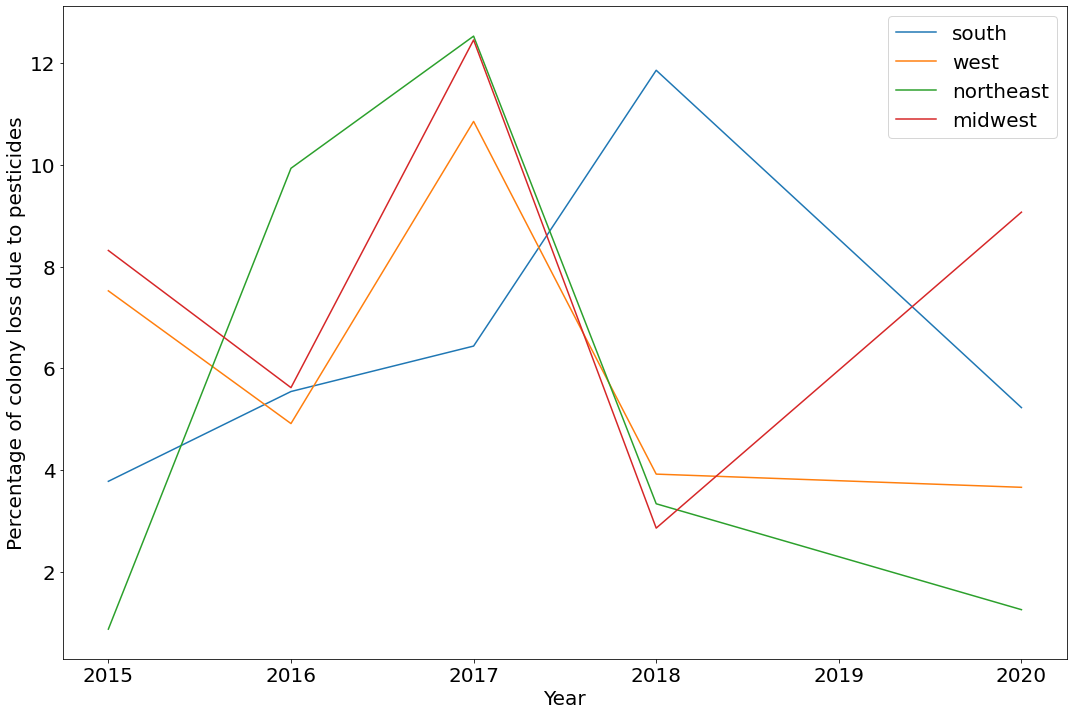

In [30]:
fig, ax = plt.subplots()
regional_q4 = bee_colony_data[bee_colony_data['quarter'] == 'Q4']
sns.lineplot(x='year', y='Pesticides', data=regional_q4, ci=None, hue="region")

ax.set_ylabel('Percentage of colony loss due to pesticides')
ax.set_xlabel('Year')
ax.legend()
plt.show()

In [31]:
bee_colony_data.to_csv('bees_post_eda.csv', index=False)